# PyTorch CNN to classify between sphere and ellipsoid

## Imporing PyTorch and setting up device-agnostic code

In [4]:
#creating responsive plot
%matplotlib widget

# Import packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Import torchvision
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Check version
print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.2


In [371]:
# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

np.random.seed(42)

# Functions and classes

In [830]:
# Generate uniform points on surface of sphere for normal projections
def projection_points(radius, num_points):
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

""" Functions that are used to generate filled sphere and
elipsoid"""

# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

# Generate points on surface of sphere
def ellipsoid(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = 1.3* r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = 0.8* r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        #plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        #ax.set_aspect('equal', 'box') #auto adjust limits
        ax.axis('equal')
        ax.set_title('Structure of Eplisoid', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

In [832]:
def points_projection(structure_coords, num_points):
    """ 
    Functions for projection
    """
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = projection_points(2, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Functiom that transforms projections into grid and no of points
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)

    return  all_grid


def image_projection(coords, size):
    '''
    # Transform projected points into image with 1s and 0s
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images

In [834]:
#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

# Function that randomoly removes points in the strucutre
def points_remover(structure_coords, percentage):
    length = len(structure_coords)
    SIZES = length * percentage //100
    indexes = sorted(np.random.choice(length, size=SIZES, replace=False), reverse=True)

    mask = np.ones(len(structure_coords), dtype=bool)
    mask[indexes] = False

    new_structure = structure_coords[mask,...]

    return new_structure


def transformer(trans_matrix, structure, reflection = False):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in point_cloud:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    # Define the translation
    tx, ty, tz = trans_matrix
    
    # Construct the translation matrix
    if reflection:
        translation_matrix = np.array([
        [-1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, -1, 0],
        [tx, ty, tz, 1],
        ])
    else:
        translation_matrix = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [tx, ty, tz, 1],
        ])
     
    # Apply the transformation to our point cloud
    translated_points = np.matmul(
        point_cloud_homogeneous,
        translation_matrix)
    
    # Convert to cartesian coordinates
    translated_points_xyz = []
    for point in translated_points:
        point = np.array(point[:-1])
        translated_points_xyz.append(point)
    '''
    # Uncomment to map original to translated points
    for i in range(len(point_cloud)):
        point = point_cloud[i]
        translated_point = translated_points_xyz[i]
        print(f'{point} → {list(translated_point)}')
    '''
    return np.array(translated_points_xyz)

def plot_structure(structure):

    x = structure[:,0]
    y = structure[:,1]
    z = structure[:,2]
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    plt.gca().set_aspect('auto', adjustable='box')
    ax.scatter(x,y,z, marker='.')
    #ax.set_aspect('equal', 'box') #auto adjust limits
    ax.axis('equal')
    ax.set_title('3D plot of structure', fontsize=10)
    plt.show()
    return

In [836]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

# TEST SCENARIO 1

## Transform dataset

In [412]:
# parameters
no_of_points = 1
no_of_image = 1
image_size = 1
grid_size = 1

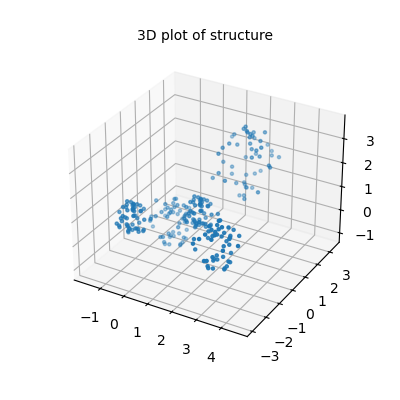

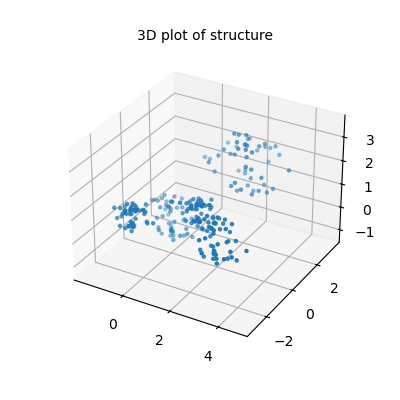

In [911]:
s1 = sphere(1,50)
a = sphere(3,50)
b= sphere(0.3,50)

s2 = transformer([2,2,2],a)
s3 = transformer([1.5,-0.5,1],b)
s4 = transformer([3,-2,1],s1)
s5 = transformer([-0.4,-2,1],b)
structure_sphere = np.concatenate((s1,s2,s3,s4,s5), axis = 0)
plot_structure(structure_sphere)

s1 = ellipsoid(1,50)
a = ellipsoid(3,50)
b= ellipsoid(0.3,50)

s2 = transformer([2,2,2],a)
s3 = transformer([1.5,-0.5,1],b)
s4 = transformer([3,-2,1],s1)
s5 = transformer([-0.4,-2,1],b)
structure_elips = np.concatenate((s1,s2,s3,s4,s5), axis = 0)
plot_structure(structure_elips)

In [864]:
#structure_sphere = sphere(1, 100)
#structure_elips = elipsoid(1,100)

#structure_sphere = points_remover(structure_sphere, 98)
#structure_elips = points_remover(structure_elips, 98)


projected_images_sphere = points_projection(structure_sphere, 20)
projected_images_eplis = points_projection(structure_elips, 20)
merged_projection = np.concatenate((projected_images_sphere, projected_images_eplis), axis=0)


label = label_making(0, projected_images_sphere)
label2 = label_making(1, projected_images_eplis)
label.extend(label2)
print(len(label))

800


In [929]:
images_bw = image_projection(merged_projection, (32,32))

# Split data set using SKlearn
data_array = np.array(images_bw) 
labels_array = np.array(label)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (640, 32, 32)
Validation data shape: (160, 32, 32)


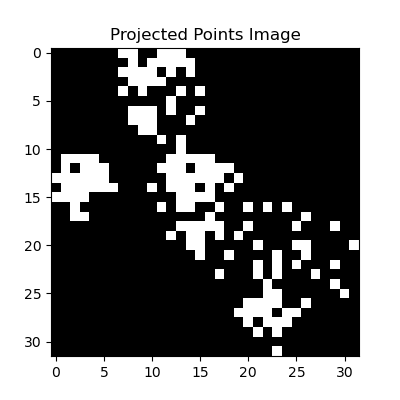

In [931]:
plt.clf()
plt.imshow(images_bw[100], cmap='gray')
plt.title('Projected Points Image')
plt.show()

In [925]:
print(images_bw[1])

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [927]:
images_grid = cluster_per_cell(merged_projection,(32,32), (10,10))

# Split data set using SKlearn
data_array = np.array(images_grid) 
labels_array = np.array(label)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (640, 10, 10)
Validation data shape: (160, 10, 10)


In [933]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [935]:
# Instantiate the dataset
BATCH_SIZE = 32
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [937]:
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...')

Length of train_dataloader: 20 batches of 32...


In [939]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2, bias=True)
)

In [941]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [943]:
# Example training loop with device
num_epochs = 5

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)  # Send data to GPU and add channel dimension
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')

print('Finished Training')

# Test model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)  # Send data to GPU and add channel dimension
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nAccuracy of the network on the validation images: {100 * correct / total}%')


# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Epoch 1, Loss: 0.6898954004049301
Epoch 2, Loss: 0.6375297129154205
Epoch 3, Loss: 0.59122613966465
Epoch 4, Loss: 0.5445505410432816
Epoch 5, Loss: 0.5112334460020065
Finished Training

Accuracy of the network on the validation images: 81.25%
Total parameters: 8354


In [902]:
# calculate size of output
print(len(images_bw[::1]))

# Tensor_size
w = 32
h  = 32

# filter_size = (fw, fh)
fw = 2
fh =2

# padding = p
# stride = s
p = 0
s = 2
out_width = ((w - fw +2*p)/s) +1
out_height = ((h - fh +2*p)/s) +1
print(f'The output shape is {out_width} x {out_height}')

800
The output shape is 16.0 x 16.0


# other model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
model.to(device)